In [1]:
import torch
from torch import nn
from PIL import Image

from tqdm import tqdm
from myutils.depth import *
from myutils.dino1 import load_dino1_model
from myutils.dino2 import load_dino2_model
from myutils.discovery import *
from myutils.pascal_voc import *
from myutils.ssl import *
from myutils.utils import *


/opt/homebrew/Caskroom/miniconda/base/envs/dado/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


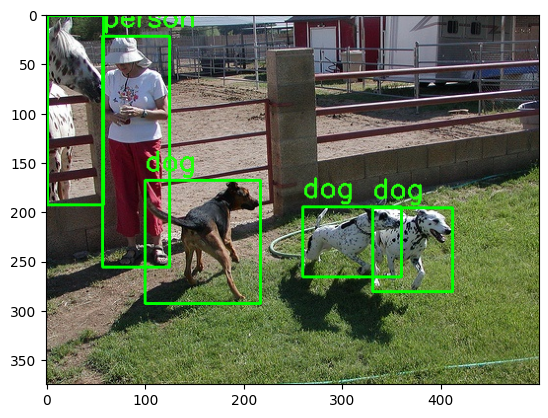

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_name = '009331'
dataset_path = "datasets/VOC2007/VOCdevkit/VOC2007"

image_path = f'{dataset_path}/JPEGImages/{img_name}.jpg'
annotation_path = f'{dataset_path}/Annotations/{img_name}.xml'

# Read an image
pil_img = load_image_as_pil(image_path)

# Convert to tensor and transform
img_tensor = load_image_as_tensor(pil_img).to(device)

# Get the ground truth
ground_truth, ground_truth_img = get_ground_truth_voc2007(annotation_path, pil_img)

plt.imshow(ground_truth_img)
plt.show()


In [3]:
ground_truth_as_list = convert_ground_truth_voc2007_to_list(ground_truth)

print(ground_truth_as_list)


[[1, 1, 58, 193], [57, 22, 125, 256], [100, 168, 217, 293], [260, 195, 360, 266], [331, 196, 412, 281]]


In [4]:
# Let´s create a function which returns an image with the ground truth
def bbox_image(image, arr_bboxes, arr_colors):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')

    for bboxes, color in zip(arr_bboxes, arr_colors):
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
    plt.show()


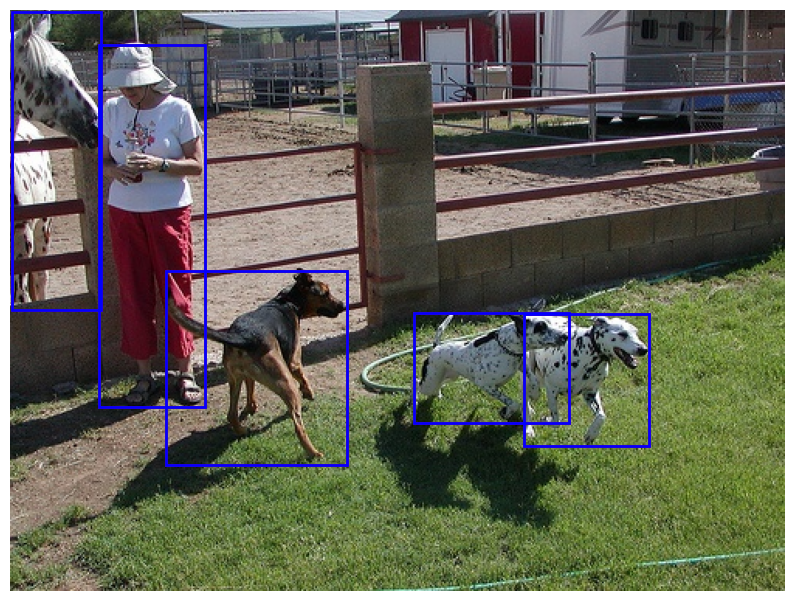

In [5]:

#proposed_objects = [[70, 20, 120, 130], [90, 160, 207, 280], [200, 190, 340, 250], [320, 180, 400, 275]]

proposed_objects = [[1, 1, 58, 193], [57, 22, 125, 256], [100, 168, 217, 293], [260, 195, 360, 266], [331, 196, 412, 281]]

bbox_image(pil_img, [ground_truth_as_list, proposed_objects], ['red', 'blue'])


In [8]:
# Calculate AP50

def bbox_iou(box1, box2, x1y1x2y2=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    # https://github.com/ultralytics/yolov5/blob/develop/utils/general.py
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    box2 = box2.T

    # Get the coordinates of bounding boxes
    if x1y1x2y2:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    else:  # transform from xywh to xyxy
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * (
        torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)
    ).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    union = w1 * h1 + w2 * h2 - inter + eps

    iou = inter / union
    if GIoU or DIoU or CIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(
            b1_x1, b2_x1
        )  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = (
                (b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2
                + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2
            ) / 4  # center distance squared
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif (
                CIoU
            ):  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(
                    torch.atan(w2 / h2) - torch.atan(w1 / h1), 2
                )
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
        else:  # GIoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + eps  # convex area
            return iou - (c_area - union) / c_area  # GIoU
    else:
        return iou  # IoU

def AP(ground_truth, proposed_objects, iou_threshold=0.5):
    """
    Calculate the Average Precision at IoU=0.5
    :param ground_truth: list of ground truth bounding boxes
    :param proposed_objects: list of proposed bounding boxes
    :return: AP50 score
    """
    # Convert to tensors
    gt_tensor = torch.tensor(ground_truth, dtype=torch.float32)
    po_tensor = torch.tensor(proposed_objects, dtype=torch.float32)

    # Calculate IoU
    iou = bbox_iou(ground_truth, proposed_objects)

    # Calculate TP and FP
    # True Positive (TP) is when IoU > threshold
    # False Positive (FP) is when IoU <= threshold
    tp = (iou > iou_threshold).sum().item()
    fp = len(proposed_objects) - tp

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(ground_truth) if len(ground_truth) > 0 else 0

    # Calculate AP50
    ap50 = (precision + recall) / 2

    return ap50

# Example usage
ap50 = AP(ground_truth_as_list, proposed_objects, iou_threshold=0.5)
print(f"AP50: {ap50:.2f}")


AttributeError: 'list' object has no attribute 'T'

In [ ]:
detected_objects = 0 # Number of objects detected by the model
ground_truth_objects = 0 # Number of objects in the ground truth
true_positives = 0 # Number of true positive detections (with IoU > 0.5)

recall = true_positives / ground_truth_objects
precision = true_positives / detected_objects
f1_score = 2 * (precision * recall) / (precision + recall)


In [1]:
import numpy as np

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0

def evaluate_at_iou(pred_boxes, gt_boxes, iou_thresh):
    TP, FP, FN = 0, 0, 0
    matched_gt = set()

    for pred in pred_boxes:
        best_iou = 0
        best_gt_idx = -1

        for i, gt_box in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            iou = compute_iou(pred, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i

        if best_iou >= iou_thresh:
            TP += 1
            matched_gt.add(best_gt_idx)
        else:
            FP += 1

    FN += len(gt_boxes) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

def compute_class_agnostic_map(pred_boxes, gt_boxes, iou_thresholds=None):
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)

    precisions = []
    for thresh in iou_thresholds:
        precision, _ = evaluate_at_iou(pred_boxes, gt_boxes, thresh)
        precisions.append(precision)

    return np.mean(precisions), precisions

# ////////////////////////////////////////////

# Entradas
ground_truth = [[1, 1, 58, 193], [57, 22, 125, 256], [100, 168, 217, 293], [260, 195, 360, 266], [331, 196, 412, 281]]
proposed_objects = [[70, 20, 120, 130], [90, 160, 207, 280], [200, 190, 340, 250], [320, 180, 400, 275]]

# Cálculo de mAP
map_val, precision_per_iou = compute_class_agnostic_map(proposed_objects, ground_truth)
print(f"mAP@[.5:.95]: {map_val:.4f}")


mAP@[.5:.95]: 0.2000


In [6]:
import base64
import numpy as np
import ast
from tqdm import tqdm

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0

def match_predictions(preds, gts, iou_thresh):
    """
    preds: lista de (image_id, box)
    gts: lista de (image_id, box)
    """
    TP = 0
    FP = 0
    matched = set()

    for pred_idx, (img_pred, pred_box) in enumerate(preds):
        best_iou = 0
        best_gt_idx = -1

        for gt_idx, (img_gt, gt_box) in enumerate(gts):
            if img_pred != img_gt:  # Sólo comparar cajas de la misma imagen
                continue
            if gt_idx in matched:
                continue
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx

        if best_iou >= iou_thresh:
            TP += 1
            matched.add(best_gt_idx)
        else:
            FP += 1

    FN = len(gts) - len(matched)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall

def compute_class_agnostic_map_dataset(pred_boxes_dict, gt_boxes_dict, iou_thresholds=None):
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)

    preds = []
    gts = []

    for img_id in tqdm(gt_boxes_dict):
        gts.extend([(img_id, box) for box in gt_boxes_dict[img_id]])
        preds.extend([(img_id, box) for box in pred_boxes_dict.get(img_id, [])])

    precisions = []

    for thresh in tqdm(iou_thresholds):
        precision, recall = match_predictions(preds, gts, thresh)
        precisions.append(precision)

    mean_ap = np.mean(precisions)
    return mean_ap, precisions



def decode_boxes(b64_string):
    # 1. Sacamos la 'b' y los quotes
    b64_string = b64_string.strip("b'").strip("'")
    # 2. Decodeamos de base64 a string
    decoded = base64.b64decode(b64_string).decode('utf-8')
    # 3. Interpretamos el string como array
    boxes = ast.literal_eval(decoded)
    return boxes

def load_results(results_filename):
    pred_boxes = {}
    gt_boxes = {}

    with open(results_filename, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            img_id = parts[1]
            ious_b64 = parts[3]
            pred_b64 = parts[4]
            gt_b64 = parts[5]

            pred = decode_boxes(pred_b64)
            gt = decode_boxes(gt_b64)

            pred_boxes[img_id] = pred
            gt_boxes[img_id] = gt

    return pred_boxes, gt_boxes

# --------- Ejemplo de uso ---------

# 1. Cargamos las predicciones y groundtruths
pred_boxes, gt_boxes = load_results("results/20241108_results.csv")

# 2. Usamos el evaluador que armamos antes
mean_ap, per_iou_precisions = compute_class_agnostic_map_dataset(pred_boxes, gt_boxes)

print(f"mAP@[.5:.95]: {mean_ap:.4f}")
for iou, prec in zip(np.arange(0.5, 1.0, 0.05), per_iou_precisions):
    print(f"IoU {iou:.2f}: Precision = {prec:.4f}")


100%|██████████| 10/10 [02:12<00:00, 13.22s/it]

mAP@[.5:.95]: 0.0134
IoU 0.50: Precision = 0.0394
IoU 0.55: Precision = 0.0298
IoU 0.60: Precision = 0.0222
IoU 0.65: Precision = 0.0163
IoU 0.70: Precision = 0.0109
IoU 0.75: Precision = 0.0070
IoU 0.80: Precision = 0.0043
IoU 0.85: Precision = 0.0025
IoU 0.90: Precision = 0.0010
IoU 0.95: Precision = 0.0005


In [ ]:
import base64
import ast
import numpy as np

def decode_boxes(b64_string):
    b64_string = b64_string.strip("b'").strip("'")
    decoded = base64.b64decode(b64_string).decode('utf-8')
    boxes = ast.literal_eval(decoded)
    return boxes

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = max(0, (box1[2] - box1[0])) * max(0, (box1[3] - box1[1]))
    area2 = max(0, (box2[2] - box2[0])) * max(0, (box2[3] - box2[1]))
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0

def load_results(results_filename):
    pred_boxes = {}
    gt_boxes = {}

    with open(results_filename, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            img_id = parts[1]
            pred_b64 = parts[4]
            gt_b64 = parts[5]

            pred = decode_boxes(pred_b64)
            gt = decode_boxes(gt_b64)

            pred_boxes[img_id] = pred
            gt_boxes[img_id] = gt

    return pred_boxes, gt_boxes

def evaluate_odap_ap50(pred_boxes_dict, gt_boxes_dict, iou_threshold=0.5):
    aps = []

    for img_id in gt_boxes_dict.keys():
        preds = pred_boxes_dict.get(img_id, [])
        gts = gt_boxes_dict[img_id]

        matched_gt = set()
        tp = 0
        fp = 0

        for pred in preds:
            matched = False
            for idx, gt in enumerate(gts):
                if idx in matched_gt:
                    continue
                iou = compute_iou(pred, gt)
                if iou >= iou_threshold:
                    matched_gt.add(idx)
                    matched = True
                    break
            if matched:
                tp += 1
            else:
                fp += 1

        fn = len(gts) - len(matched_gt)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        ap = precision  # En odAP con fixed predictions, AP ≈ Precision@Recall
        aps.append(ap)

    odap_ap50 = np.mean(aps) if aps else 0.0
    return odap_ap50

# ---------------------------

# Ejemplo de uso:
# results_file = "ruta_a_tu_results_file.txt"
pred_boxes, gt_boxes = load_results("results/20241108_voc12_results.csv")
odap_ap50 = evaluate_odap_ap50(pred_boxes, gt_boxes, iou_threshold=0.45)

print(f"odAP (AP50) en todo el dataset: {odap_ap50:.4f}")


odAP (AP50) en todo el dataset: 0.0616


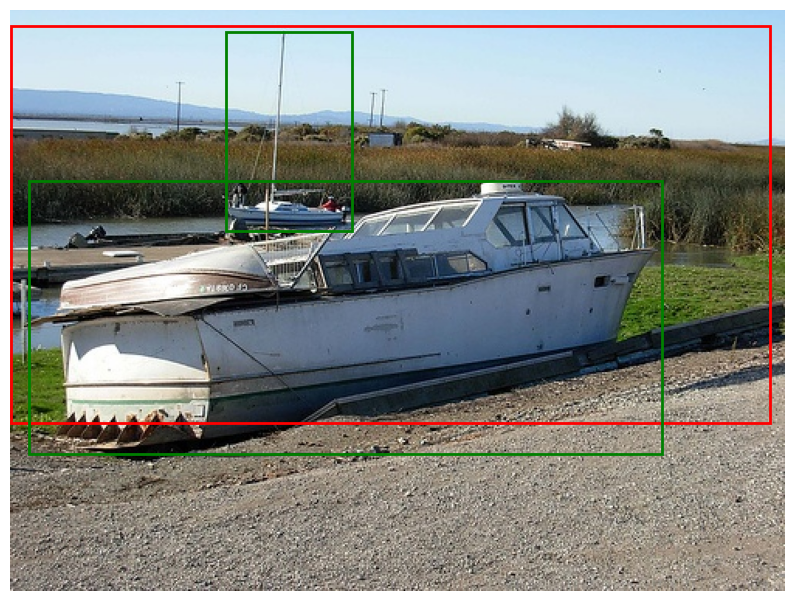

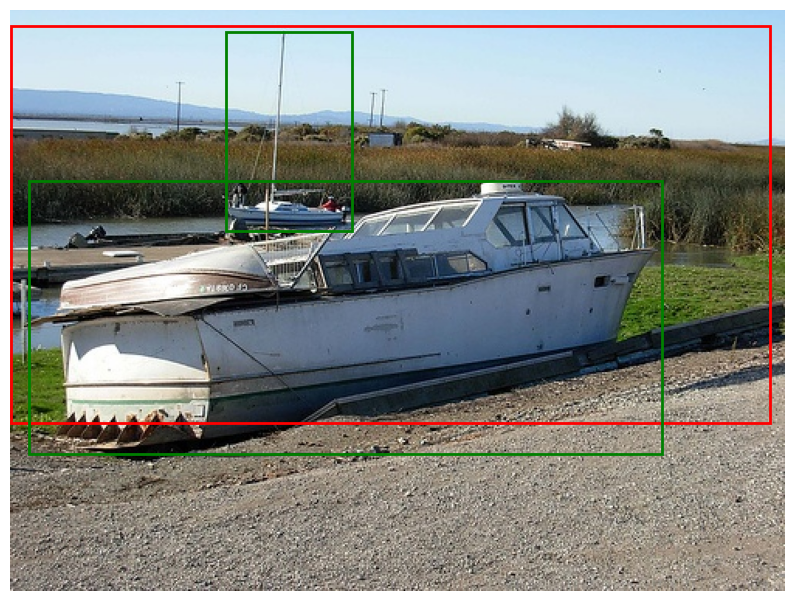

In [7]:
import base64
import ast
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def decode_boxes(b64_string):
    b64_string = b64_string.strip("b'").strip("'")
    decoded = base64.b64decode(b64_string).decode('utf-8')
    boxes = ast.literal_eval(decoded)
    return boxes

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = max(0, (box1[2] - box1[0])) * max(0, (box1[3] - box1[1]))
    area2 = max(0, (box2[2] - box2[0])) * max(0, (box2[3] - box2[1]))
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0


def bbox_image(image, arr_bboxes, arr_colors):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')

    for bboxes, color in zip(arr_bboxes, arr_colors):
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
    plt.show()


def load_result(line):
    parts = line.strip().split(',')
    id = parts[0]
    img_name = parts[1]
    corloc = parts[2]
    ious_b64 = parts[3]
    pred_b64 = parts[4]
    gt_b64 = parts[5]

    ious = decode_boxes(ious_b64)
    pred = decode_boxes(pred_b64)
    gt = decode_boxes(gt_b64)

    return id, img_name, corloc, ious, pred, gt


line_good = "4,000608,1.0,b'W1swLjA3OTU0NTgwMzM2ODA5MTU4LCAwLjUwMzg1MzYxOTA5ODY2MzNdXQ==',b'W1swLCAxMCwgNDkwLCAyNjZdXQ==',b'W1sxMzksIDE0LCAyMjAsIDE0Ml0sIFsxMiwgMTEwLCA0MjAsIDI4Nl1d'"
line__bad = "4,000608,0.0,b'WzAuMjM5NjgwODM0NzM5OTExLCAwLjM4NTc0NzQ4MjU3MTY0OTg3XQ==',b'W1swLCAxMCwgNDkwLCAyNjZdXQ==',b'W1sxMzksIDE0LCAyMjAsIDE0Ml0sIFsxMiwgMTEwLCA0MjAsIDI4Nl1d'"


# Load the image, and draw it with the pred and gt boxes
id, img_name, corloc, ious, pred, gt = load_result(line_good)
img = Image.open(f"datasets/VOC2007/VOCdevkit/VOC2007/JPEGImages/{img_name}.jpg")
bbox_image(img, [pred, gt], ['red', 'green'])

# Load the image, and draw it with the pred and gt boxes
id, img_name, corloc, ious, pred, gt = load_result(line__bad)
img = Image.open(f"datasets/VOC2007/VOCdevkit/VOC2007/JPEGImages/{img_name}.jpg")
bbox_image(img, [pred, gt], ['red', 'green'])

